In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import ER_multiclass as ER

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# load data
df = pd.read_csv('../gene_sequence_data.txt',sep= ',',header=None)

In [4]:
df.columns = ['class', 'name', 'seq']

In [5]:
df = df[['seq','class']]
df.head()

,seq,class
0,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...,EI
1,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...,EI
2,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...,EI
3,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...,EI
4,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...,EI


In [6]:
# remove empty space
df['seq'] = df['seq'].str.strip()

# attributes
X = df['seq']
X = np.array([list(X[t]) for t in range(len(X))])
X.shape

(3190, 60)

In [7]:
# delete rows containing bad letters
bad_letters = ['D','N','S','R']
bad_rows = []
for bad_letter in bad_letters:
    t = np.unique(np.where(X == bad_letter)[0])
    bad_rows = np.concatenate((bad_rows, t), axis=0)
    
bad_rows = np.unique(bad_rows).astype(int)
bad_rows

array([ 107,  239,  365,  366,  485, 1247, 1440, 1441, 1804, 2069, 2135,
       2578, 2636, 2637, 2910])

In [8]:
X = np.delete(X,bad_rows,axis=0)

In [9]:
y = np.array(df['class'])
y = np.delete(y,bad_rows)
y.shape

(3175,)

In [10]:
np.unique(y,return_counts=True)

(array(['EI', 'IE', 'N'], dtype=object), array([ 762,  765, 1648]))

In [11]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')

In [12]:
X = onehot_encoder.fit_transform(X)
X.shape

(3175, 240)

In [13]:
y = onehot_encoder.fit_transform(y.reshape(-1,1))

y = np.argmax(y,axis=1)
y.shape

(3175,)

## Shuffle data

In [14]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [15]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [16]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=100,regu=0.1)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(multi_class='multinomial',solver='saga')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [17]:
def compare_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)

        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [18]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which 

0.8 [0.94650394 0.93244094 0.85711811 0.95850394]


/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which 

0.6 [0.94314961 0.92407874 0.85766929 0.95683465]


/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which 

/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which 

0.4 [0.94069291 0.91335433 0.85822047 0.95418898]


/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which 

/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which 

/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which 

0.2 [0.9327874  0.9116063  0.83987402 0.94409449]


In [19]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,expectation_reflection
0,0.8,0.946504,0.932441,0.857118,0.958504
1,0.6,0.943150,0.924079,0.857669,0.956835
2,0.4,0.940693,0.913354,0.858220,0.954189
3,0.2,0.932787,0.911606,0.839874,0.944094


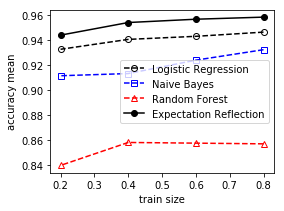

In [20]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy mean')
plt.legend()

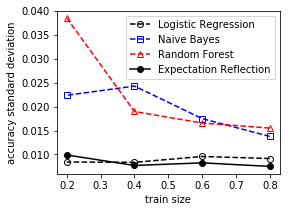

In [21]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc_std[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc_std[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc_std[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc_std[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy standard deviation')
plt.legend()